In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from mabwiser.mab import MAB, LearningPolicy

import matplotlib.pyplot as plt
from IPython.display import clear_output

np.random.seed(2025)

# Carregar Dados

In [4]:
df = pd.read_csv('../dataset/raw/dataset.csv')
# df.drop(columns=['reward', 'periodo_dia'], inplace=True)
df['date'] = pd.to_datetime(df['date'])
df['safra'] = df['date'].dt.to_period('M').astype(str)
df.head()

,date,periodo_dia,dia_semana,segmento,tempo_cliente,qtd_cliques_30d,usou_app_hoje,dias_desde_ultimo_clique,reward,safra
0,2024-01-01,tarde,seg,medio_valor,834,1,0,37,0,2024-01
1,2024-01-01,noite,seg,medio_valor,37,1,0,86,0,2024-01
2,2024-01-01,manha,seg,baixo_valor,163,3,0,61,0,2024-01
3,2024-01-01,tarde,seg,medio_valor,854,1,1,69,0,2024-01
4,2024-01-01,manha,seg,alto_valor,19,2,1,75,0,2024-01


In [5]:
features_import = joblib.load('../dataset/processed/features_importantes.pkl')
preprocessor = joblib.load('../dataset/processed/preprocessor.pkl')

# Simulação

In [6]:
# Manhã:0 | Tarde: 1 | Noite:2
mapeamento = {0: 'manha', 1: 'tarde', 2: 'noite'}
actions =  [0, 1, 2]

cols_numeric = ['tempo_cliente', 'qtd_cliques_30d', 'dias_desde_ultimo_clique']
cols_categoric = ['dia_semana', 'segmento']
cols_inf = ['date', 'safra', 'usou_app_hoje']

In [7]:
def encoder_dataset(df_contx):
    # Fit-transform
    X_transformed = preprocessor.transform(df_contx)

    # Pegar os nomes das colunas
    ohe = preprocessor.named_transformers_['cat']
    ohe_features = ohe.get_feature_names_out(cols_categoric)
    feature_names = list(ohe_features) + cols_numeric

    # Converter para DataFrame
    X_final = pd.DataFrame(X_transformed.toarray() if hasattr(X_transformed, 'toarray') else X_transformed,
                        columns=feature_names,
                        index=df_contx.index)


    df_transformer = pd.concat([df_contx[cols_inf], X_final], axis=1)

    return df_transformer

In [8]:
def simular_recompensa(row):
    p = 0.02  # baseline reduzido

    # Impacto do segmento
    segmento_bonus = {
        'alto_valor': 0.20,
        'medio_valor': 0.10,
        'baixo_valor': 0.00
    }
    p += segmento_bonus.get(row['segmento'], 0)

    # Interação entre segmento e período do dia
    if row['segmento'] == 'alto_valor':
        if row['periodo_dia'] == 'manha':
            p += 0.10
        elif row['periodo_dia'] == 'tarde':
            p -= 0.03
    elif row['segmento'] == 'medio_valor':
        if row['periodo_dia'] == 'tarde':
            p += 0.07
    elif row['segmento'] == 'baixo_valor':
        if row['periodo_dia'] == 'noite':
            p += 0.08
        elif row['periodo_dia'] == 'manha':
            p -= 0.02

    # Engajamento anterior
    p += min(row['qtd_cliques_30d'] * 0.008, 0.1)

    # Uso do app no dia
    if row['usou_app_hoje']:
        p += 0.04

    # Dia da semana
    if row['dia_semana'] == 'sex':
        p -= 0.04
    elif row['dia_semana'] == 'seg':
        p += 0.02  # segundas são melhores

    # Tempo de cliente
    if row['tempo_cliente'] < 30:
        p -= 0.03
    elif row['tempo_cliente'] > 365:
        p += 0.02  # clientes antigos clicam mais

    # Último clique
    if row['dias_desde_ultimo_clique'] < 3:
        p += 0.04
    elif row['dias_desde_ultimo_clique'] > 30:
        p -= 0.02

    # Clipping
    p = max(0.001, min(p, 0.95))

    return int(np.random.rand() < p)

In [19]:
def create_models_cmab_mab(df_simu, list_features, action_list):
    df_tmp = df_simu[df_simu['safra'].isin(['2024-01', '2024-02', '2024-03'])]
    df_tmp['periodo_dia'] = df_tmp['periodo_dia'].map({'manha':0, 'tarde':1, 'noite':2})
    df_tmp_enc = encoder_dataset(df_tmp)
    
    arms = sorted(set(action_list))

    mab_contextual_leg = MAB(arms=arms, learning_policy=LearningPolicy.LinGreedy(epsilon=0.1), seed=2025, n_jobs=-1)
    mab_nao_contextual_eg = MAB(arms=arms, learning_policy=LearningPolicy.EpsilonGreedy(epsilon=0.1), seed=2025, n_jobs=-1)
    
    mab_contextual_leg.partial = True
    mab_nao_contextual_eg.partial = True
    
    mab_contextual_leg.fit(decisions=list(df_tmp['periodo_dia'].values), rewards=list(df_tmp['reward'].values), contexts=df_tmp_enc[list_features])
    mab_nao_contextual_eg.fit(decisions=list(df_tmp['periodo_dia'].values), rewards=list(df_tmp['reward'].values))

    return mab_contextual_leg, mab_nao_contextual_eg


In [20]:
def predict_baseline_batch(contexto):
    preds = np.random.choice(actions, size=contexto.shape[0], p=[0.31844411, 0.34473178, 0.33682411])

    contexto['periodo_dia'] = preds
    rewards_calc = contexto.apply(simular_recompensa, axis=1)
    rewards_calc = list(rewards_calc)
    
    return rewards_calc

def predict_cmab_batch(df_contx, mab_contextual):
    contx_encoder = encoder_dataset(df_contx)
    
    preds = mab_contextual.predict(contexts=contx_encoder[features_import])    
    preds_convert = list(map(mapeamento.get, preds))
    df_contx['periodo_dia'] = preds_convert
    
    rewards_calc = df_contx.apply(simular_recompensa, axis=1)
    rewards_calc = list(rewards_calc)
    
    return contx_encoder, preds, rewards_calc

def predict_mab_batch(df_contx, mab_nao_contextual):
    preds = [mab_nao_contextual.predict() for _ in range(0, df_contx.shape[0])]
    
    df_contx['periodo_dia'] = preds
    rewards_calc = df_contx.apply(simular_recompensa, axis=1)
    rewards_calc = list(rewards_calc)
    
    return preds, rewards_calc

In [ ]:
def simulacao(df_simu):
    
    mab_contextual_leg, mab_nao_contextual_eg = create_models_cmab_mab(df_simu, features_import, actions)
    
    # Histórico
    cumulative_baseline = 0
    cumulative_contextual_leg = 0
    cumulative_nao_contextual_eg = 0
    
    hist_cumulative_baseline = []
    hist_cumulative_contextual_leg = []
    hist_cumulative_nao_contextual_eg = []

    x_data = [] 

    y_cmab_leg = []
    y_mab_eg = []
    y_base = []

    total_sends = 0
    
    df_simu_filter = df_simu[~df_simu['safra'].isin(['2024-01', '2024-02', '2024-03'])]

    list_dates = sorted(set(df_simu_filter['date'].unique()))

    for index, date in enumerate(list_dates):
        df_tmp = df_simu_filter[df_simu_filter['date']==date]
        
        # --- BASELINE ---
        rewards_b = predict_baseline_batch(df_tmp.copy())
        cumulative_baseline += sum(rewards_b)
        hist_cumulative_baseline.append(cumulative_baseline)
        
        # --- CMAB ---
        contx_encoder, preds_ctx, rewards_ctx = predict_cmab_batch(df_tmp.copy(), mab_contextual_leg)
        mab_contextual_leg.fit(decisions=preds_ctx, rewards=rewards_ctx, contexts=contx_encoder[features_import])
        cumulative_contextual_leg += sum(rewards_ctx)
        hist_cumulative_contextual_leg.append(cumulative_contextual_leg)
        
        # --- MAB ---
        preds_mab, rewards_mab = predict_mab_batch(df_tmp.copy(), mab_nao_contextual_eg)
        mab_nao_contextual_eg.fit(decisions=preds_mab, rewards=rewards_mab)
        cumulative_nao_contextual_eg += sum(rewards_mab)
        hist_cumulative_nao_contextual_eg.append(cumulative_nao_contextual_eg)
        
        total_sends += len(rewards_mab)

        # Gráfico =============
        x_data.append(index+1)
        
        y_cmab_leg.append((sum(rewards_ctx)*100)/len(rewards_ctx))
        y_mab_eg.append((sum(rewards_mab)*100)/len(rewards_mab))
        y_base.append((sum(rewards_b)*100)/len(rewards_b))
        
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(12, 6))
        
        ax.plot(x_data, y_cmab_leg, label="LinGreedy (Contextual)")
        ax.plot(x_data, y_mab_eg, label="EpsilonGreedy (Não-Contextual)")
        ax.plot(x_data, y_base, label="Baseline", linestyle="--")

        ax.set_xlabel("Interações")
        ax.set_ylabel("Taxa de Acerto (%)")
        ax.set_title("Taxa de Acerto por Interação: CMAB vs MAB vs Baseline")
        ax.legend()
        # ax.grid(True)
        ax.set_ylim(0.0, 35.0)
        plt.tight_layout()
        plt.show()
    
    return x_data, hist_cumulative_contextual_leg, hist_cumulative_nao_contextual_eg, hist_cumulative_baseline


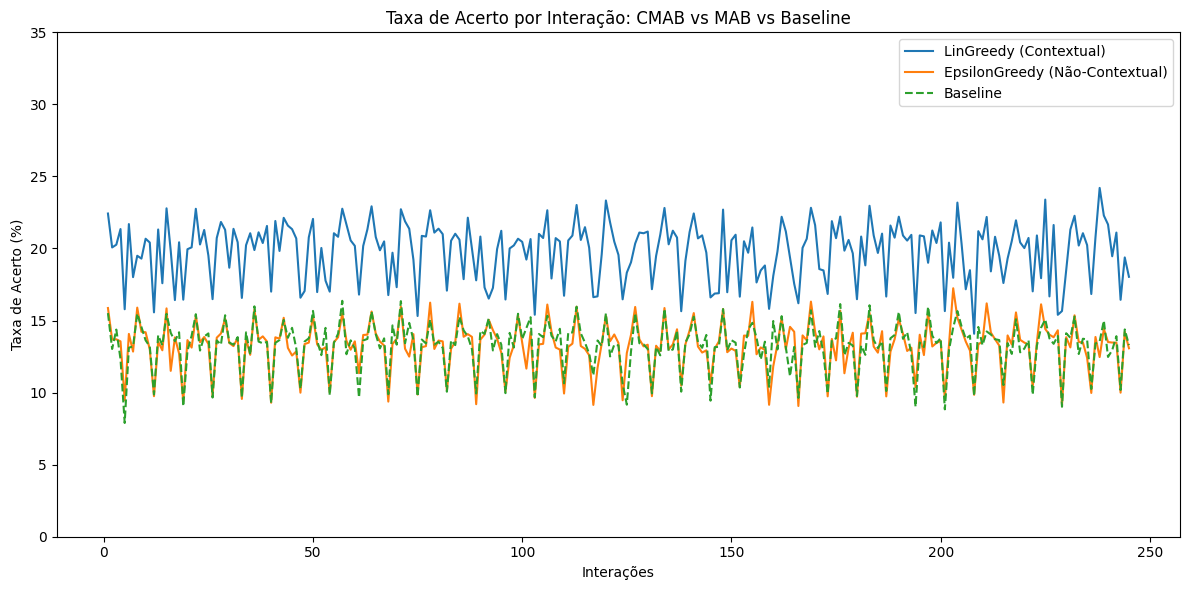

In [24]:
x_data, hist_cumulative_contextual_leg, hist_cumulative_nao_contextual_eg, hist_cumulative_baseline = simulacao(df)

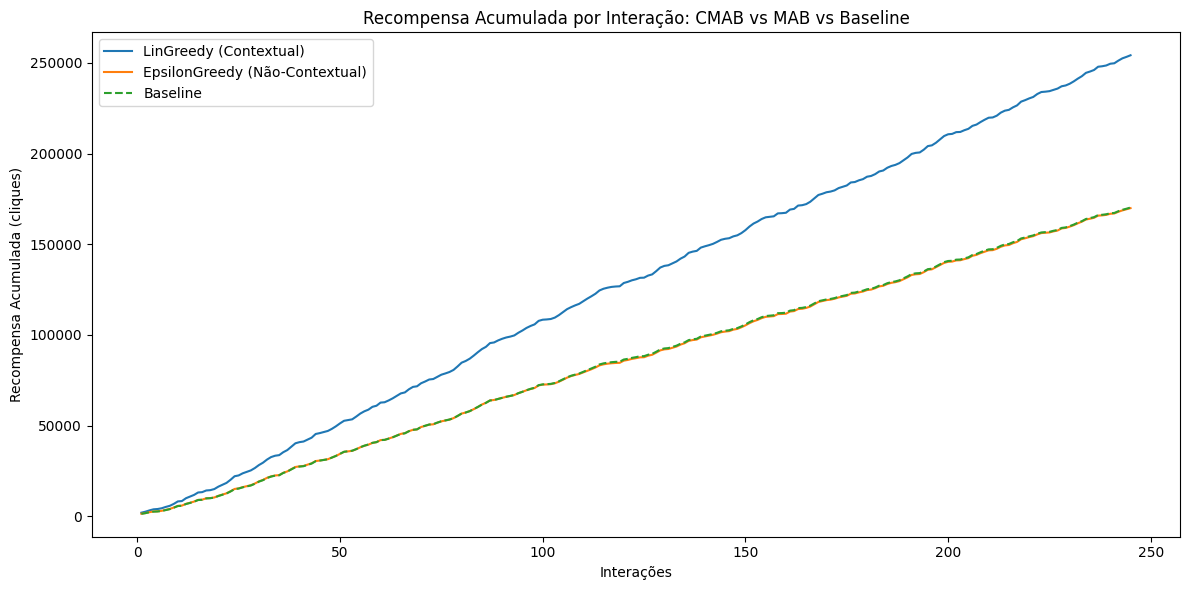

In [25]:
x_data, hist_cumulative_contextual_leg, hist_cumulative_nao_contextual_eg

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(x_data, hist_cumulative_contextual_leg, label="LinGreedy (Contextual)")
ax.plot(x_data, hist_cumulative_nao_contextual_eg, label="EpsilonGreedy (Não-Contextual)")
ax.plot(x_data, hist_cumulative_baseline, label="Baseline", linestyle="--")

ax.set_xlabel("Interações")
ax.set_ylabel("Recompensa Acumulada (cliques)")
ax.set_title("Recompensa Acumulada por Interação: CMAB vs MAB vs Baseline")
ax.legend()
# ax.grid(True)
plt.tight_layout()
plt.show()